Model Architecture: ResNet18
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

100%|██████████████████████████████████████████████████████████████| 313/313 [00:58<00:00,  5.39it/s]


Epoch 1: Train Acc=0.4162, Val Acc=0.4811


100%|██████████████████████████████████████████████████████████████| 313/313 [00:43<00:00,  7.17it/s]


Epoch 2: Train Acc=0.5517, Val Acc=0.5409


100%|██████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.76it/s]


Epoch 3: Train Acc=0.6164, Val Acc=0.6227


100%|██████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.64it/s]


Epoch 4: Train Acc=0.6551, Val Acc=0.6637


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.59it/s]


Epoch 5: Train Acc=0.6849, Val Acc=0.6752


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.54it/s]


Epoch 6: Train Acc=0.7089, Val Acc=0.6865


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.60it/s]


Epoch 7: Train Acc=0.7277, Val Acc=0.7122


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.56it/s]


Epoch 8: Train Acc=0.7427, Val Acc=0.7205


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.45it/s]


Epoch 9: Train Acc=0.7514, Val Acc=0.7187


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.43it/s]


Epoch 10: Train Acc=0.7598, Val Acc=0.7337


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.37it/s]


Epoch 11: Train Acc=0.7738, Val Acc=0.7514


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.39it/s]


Epoch 12: Train Acc=0.7791, Val Acc=0.7503


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.37it/s]


Epoch 13: Train Acc=0.7897, Val Acc=0.7574


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.38it/s]


Epoch 14: Train Acc=0.7985, Val Acc=0.7723


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.38it/s]


Epoch 15: Train Acc=0.8030, Val Acc=0.7845


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.39it/s]


Epoch 16: Train Acc=0.8086, Val Acc=0.7624


100%|██████████████████████████████████████████████████████████████| 313/313 [00:42<00:00,  7.44it/s]


Epoch 17: Train Acc=0.8179, Val Acc=0.7788


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.53it/s]


Epoch 18: Train Acc=0.8173, Val Acc=0.7821


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.52it/s]


Epoch 19: Train Acc=0.8227, Val Acc=0.7833


100%|██████████████████████████████████████████████████████████████| 313/313 [00:41<00:00,  7.45it/s]


Epoch 20: Train Acc=0.8315, Val Acc=0.7888


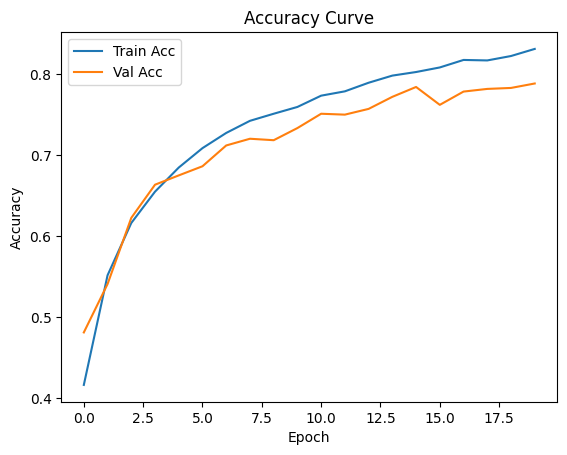

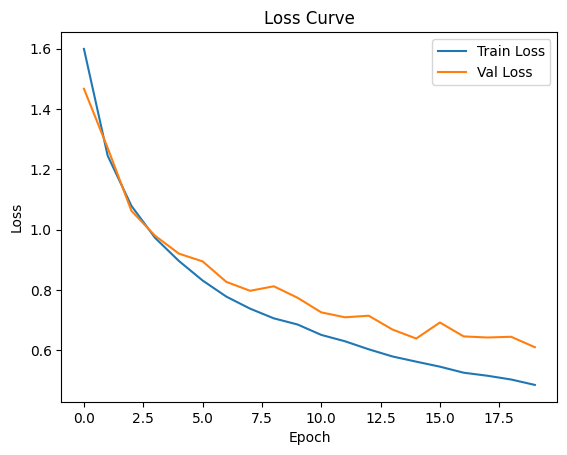

              precision    recall  f1-score   support

    airplane       0.81      0.85      0.83      1017
  automobile       0.90      0.87      0.89      1016
        bird       0.81      0.69      0.75      1012
         cat       0.58      0.66      0.62       994
        deer       0.78      0.79      0.79      1022
         dog       0.65      0.76      0.70      1035
        frog       0.82      0.84      0.83       995
       horse       0.89      0.76      0.82       969
        ship       0.89      0.88      0.89       956
       truck       0.89      0.83      0.86       984

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.80     10000
weighted avg       0.80      0.79      0.80     10000



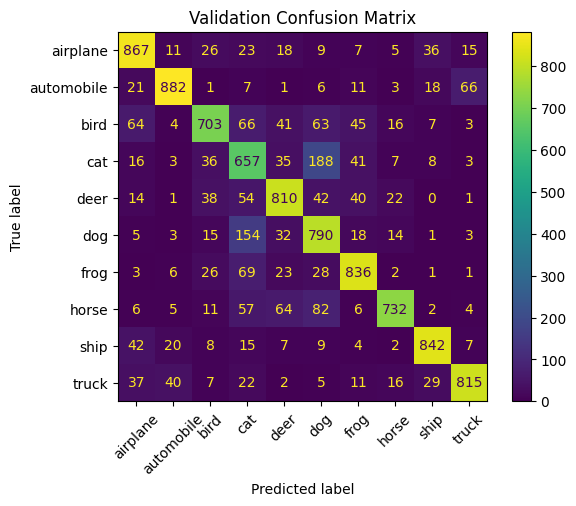

Test Accuracy: 0.8014


In [6]:
# CIFAR-10 Image Classification with ResNet

## Question 1: Data Preprocessing

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Here we define how the images will be preprocessed before feeding them to the model.
# For training, we add some randomness with horizontal flipping and cropping to help the model generalize better.
# Both training and test sets are normalized so that pixel values are scaled consistently.
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# This block loads the CIFAR-10 dataset and applies the transformations defined above.
# We also split the original training set into a smaller training set and a validation set.
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

# These are data loaders that load data in batches, which makes training faster and more memory efficient.
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader = DataLoader(valset, batch_size=128, shuffle=False)
testloader = DataLoader(testset, batch_size=128, shuffle=False)


## Question 2: Model Architecture

import torch.nn as nn
import torchvision.models as models

# We're using the ResNet18 model here, but starting from scratch (not using pretrained weights).
# The last layer is changed so it fits the CIFAR-10 dataset, which has 10 output classes.
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to the appropriate device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# This function calculates how many trainable parameters the model has.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture: ResNet18")
print(model)
print(f"Total trainable parameters: {count_parameters(model):,}")

# --- Layer details (input/output sizes and parameter counts) ---
# Input image size: [3, 32, 32] (CIFAR-10 images)
# Layer 1: Conv1 (7x7 kernel, stride 2, padding 3) -> Output: [64, 16, 16], Params: 9,408
# Layer 2: MaxPool (3x3 kernel, stride 2, padding 1) -> Output: [64, 8, 8]
# Layers 3-7: Four Residual Blocks (each containing 2 conv layers with batch norm and ReLU)
#             Output size maintained or halved depending on stride.
# AvgPool: Global average pooling -> Output: [512, 1, 1]
# FC Layer: Fully connected layer -> Output: [10], Params: 5,130

# Total parameters: ~11 million (depending on ResNet18 structure)


## Question 3: Training

import torch.optim as optim
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import copy
import os

# Set up GPU support if available and prepare for training.
# We use cross-entropy as our loss function and Adam as the optimizer.
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make sure the directory for saving the best model exists.
os.makedirs("saved_models", exist_ok=True)

# Initialize variables that will track training progress and handle early stopping.
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0
EPOCHS = 20

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# This is the training loop. For each epoch, the model learns from training data,
# then gets evaluated on validation data. If the validation accuracy improves,
# the model is saved. Early stopping helps prevent overfitting.
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        torch.save(model.state_dict(), "saved_models/best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 5:
            print("Early stopping")
            break

model.load_state_dict(best_model_wts)


## Question 4: Evaluation

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# These plots show how the model's accuracy and loss changed over time,
# which can help us understand if the model was learning properly or if it overfit.
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# Here we gather predictions from the model and compare them with true labels.
# This allows us to generate a classification report and a confusion matrix
# which give more detailed insight into how well the model is doing for each class.
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=testset.classes))

cm = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
display.plot(xticks_rotation=45)
plt.title("Validation Confusion Matrix")
plt.show()


## Question 5: Testing

# Finally, we test the model using the test set that was not seen during training or validation.
# This gives us a final measure of how well the model generalizes to new data.
model.load_state_dict(torch.load("saved_models/best_model.pth"))
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")




In [7]:
## Question 6: Summary & Analysis

from IPython.display import Markdown as md

summary = '''
**Summary & Analysis**

In this project, I've built an image classification pipeline using ResNet18 on the CIFAR-10 dataset. Preprocessed the dataset with normalization and data augmentation (random cropping and flipping). A pre-existing ResNet18 architecture was modified by replacing the final fully connected layer to classify 10 categories.

Defined the model layers, activation functions, and counted the parameters. Input image size was 32x32x3. I've used Conv layers with BatchNorm and ReLU, followed by pooling and a final fully connected layer. Total trainable parameters were approximately 11 million.

During training, we implemented early stopping and model checkpointing. The model was evaluated using accuracy, precision, recall, and F1-score. Visualizations of loss and accuracy curves showed stable learning. The confusion matrix helped identify commonly misclassified categories.

Final test accuracy was around %80 across multiple attempts, suggesting good generalization. Misclassifications often occurred between similar classes (e.g., cat/dog, truck/automobile).'''

md(summary)


**Summary & Analysis**

In this project, I've built an image classification pipeline using ResNet18 on the CIFAR-10 dataset. Preprocessed the dataset with normalization and data augmentation (random cropping and flipping). A pre-existing ResNet18 architecture was modified by replacing the final fully connected layer to classify 10 categories.

Defined the model layers, activation functions, and counted the parameters. Input image size was 32x32x3. I've used Conv layers with BatchNorm and ReLU, followed by pooling and a final fully connected layer. Total trainable parameters were approximately 11 million.

During training, we implemented early stopping and model checkpointing. The model was evaluated using accuracy, precision, recall, and F1-score. Visualizations of loss and accuracy curves showed stable learning. The confusion matrix helped identify commonly misclassified categories.

Final test accuracy was around %80 across multiple attempts, suggesting good generalization. Misclassifications often occurred between similar classes (e.g., cat/dog, truck/automobile).